In [ ]:
# This code is part of Qiskit.
#
# (C) Copyright IBM 2022.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

## Prerequisites

### Load Qiskit and Required Libraries

In [1]:
run_experiment = False
dynamical_decoupling = False

from qiskit import IBMQ, transpile, schedule, pulse
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import XGate, YGate
from qiskit.pulse import DriveChannel
import qiskit.quantum_info as qi

from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

from qiskit.opflow import (I, X, Y, Z, Zero, One, MatrixEvolution, PauliTrotterEvolution, Suzuki,
                           StateFn, Zero, One, PauliExpectation, PauliOp, SummedOp, OperatorBase)

from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import TemplateOptimization, ALAPSchedule, DynamicalDecoupling
from qiskit.transpiler.passes.calibration import RZXCalibrationBuilder, rzx_templates

from qiskit.converters import circuit_to_dag, dag_to_circuit # for bespoke transpilation
from qiskit.dagcircuit import DAGCircuit, DAGNode

from qiskit.scheduler.config import ScheduleConfig
from qiskit.visualization import plot_circuit_layout, plot_error_map, timeline_drawer

import copy
import numpy as np
import scipy.linalg as lng
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [5, 5]

### Load IBM Quantum Account
Try Nick's then John's.

In [2]:
IBMQ.load_account()
try:
    #provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
    provider = IBMQ.get_provider(hub='ibm-q-internal', group='mission-critical', project='bronn')
    backend = provider.get_backend('ibm_lagos')
except:
    provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
    backend = provider.get_backend('ibmq_bogota') # checking gate directions

### Load Backend Information (for Pulse)

In [3]:
backend_config = backend.configuration()
dt = backend_config.dt
meas_map = backend_config.meas_map

backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map

sched_config = ScheduleConfig(inst_sched_map, meas_map, dt)

# Build Circuits from Model Hamiltonian

## Define the System Hamiltonian

John wrote down the system Hamiltonian as

$$ H = \mu\sum_{i=0}^N c^{\dagger}_i c_i + t \sum_{i=0}^{N-1} (c^{\dagger}_ic_{i+1} + c^{\dagger}_{i+1}c_i) + \Delta \sum_{i=0}^{N-1}(c^{\dagger}_i c^{\dagger}_{i+1} + c_{i+1}c_i) + U \sum_{i=0}^{N-1} c^{\dagger}_i c_i c^{\dagger}_{i+1} c_{i+1} $$

where we can use the new `FermionicOp` class to write this general Hamiltonian for 2 site.

In terms of Majorana operators $\gamma^x_i = c^{\dagger}_i + c_i$ and $\gamma^y_i = i(c^{\dagger}_i - c_i)$ we have

$$ H = -\frac{2\mu + U}{4} \sum_{i=0}^N\gamma^x_i\gamma^y_i + \frac{t+\Delta}{2}\sum_{i=0}^{N-1} \gamma^x_i\gamma^y_{i+1} + \frac{t-\Delta}{2} \sum_{i=0}^{N-1} \gamma^y_i\gamma^x_{i+1} + \frac{U}{4}  \sum_{i=0}^{N-1}\gamma^x_i\gamma^y_i\gamma^x_{i+1}\gamma^y_{i+1}$$

In [4]:
hm = sum(FermionicOp(label) for label in ['IN', 'NI'])
ht = FermionicOp('+-') - FermionicOp('-+')
hD = FermionicOp('++') - FermionicOp('--')
hU = sum(FermionicOp(label) for label in ['NN'])

<ipython-input-4-9e352dd89e7e>:1: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  hm = sum(FermionicOp(label) for label in ['IN', 'NI'])


### Transform Fermionic to Pauli Hamiltonian
Bravyi-Kitaev and BKSuperFast are also built into Qiskit.

In [5]:
mapper = JordanWignerMapper()
converter = QubitConverter(mapper=mapper) # should not give 2-qubit reduction error

# parameters defined here due to incompatibility with Qiskit Nature
mu = Parameter('μ')
TT = Parameter('T')
DD = Parameter('Δ')
UU = Parameter('U')

hm_pauli = mu*(converter.convert(hm))
ht_pauli = TT*(converter.convert(ht))
hD_pauli = DD*(converter.convert(hD))
hU_pauli = UU*(converter.convert(hU))

ham_pauli = hm_pauli + ht_pauli + hD_pauli + hU_pauli
print(ham_pauli)

SummedOp([
  1.0*μ * (
    1.0 * II
    - 0.5 * ZI
    - 0.5 * IZ
  ),
  1.0*T * (
    0.5 * XX
    + 0.5 * YY
  ),
  1.0*Δ * (
    0.5 * XX
    - 0.5 * YY
  ),
  1.0*U * (
    0.25 * II
    - 0.25 * ZI
    - 0.25 * IZ
    + 0.25 * ZZ
  )
])


## Build Resonance Hamiltonian

Converting John's notation to little-endian:
$$H = -\frac{1}{2}\omega IIZ + H_{\rm Pauli}\otimes I + c IXX$$
Parsing in `opflow` is very dependent on how you build Hamiltonian.

In [6]:
cc = Parameter('c')
ww = Parameter('ω')

def build_resonance_ham(h0: OperatorBase) -> SummedOp:
    nq = h0.num_qubits
    h_jw = []
    for op in h0:
        for pop in op:
            h_jw.append((pop^I).to_pauli_op())
    oplist = [-0.5*ww*((I^(nq))^Z), cc*((I^(nq-1))^X^X)]
    oplist += h_jw
    return SummedOp(oplist)

## Time Evolve Resonance Hamiltonian

In [7]:
tt = Parameter('t')
res_ham = build_resonance_ham(ham_pauli)
U_ham = (tt*res_ham).exp_i()
#print(U_ham)

## Trotterize Unitary Evolution Operator
Why do random subcircuit appear sometimes? One hypothesis: parsing each coefficient with `Parameter`s expanded vs being multiplied by a grouping of `PauliOp`s might be it (observed this behavior at Heidelberg workshop).

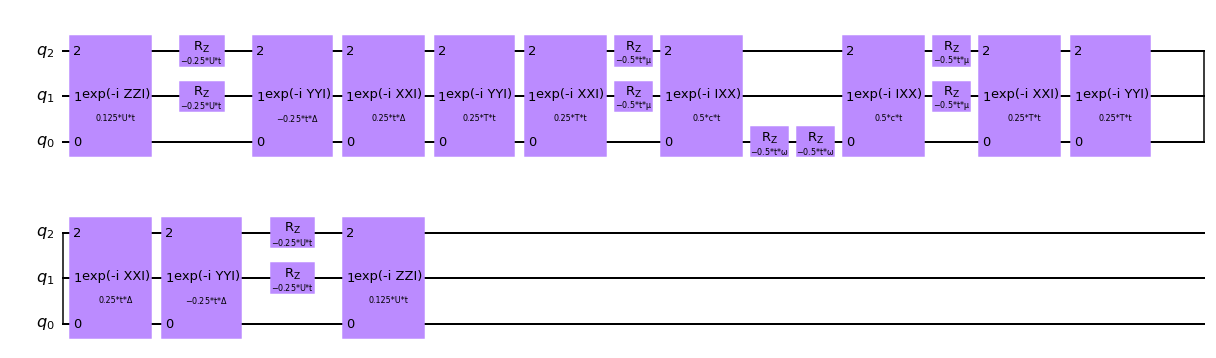

In [8]:
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=1)).convert(U_ham)
trot_circ = trot_op.to_circuit()
trot_circ.draw(output='mpl', reverse_bits=True)

# Transpile Circuits to Quantum Backend

## *Incredibly* useful notes on what we're doing

Transpilation will take place "by hand" so that we can introduce the template optimization at the correct point. Each *pass* of the transpiler is classified as either an analysis or transformation pass. Template optimization consists of two passes:
- `TemplateOptimization` is an analysis pass that adds the templates (similar to circuit equivalences), in this case specified by `rzx_templates()` 
- `RZXCalibrationBuilder` is a transformation pass that replaces $ZX(\theta)$ gates with the locally-equivalent scaled Pulse gates

The **order** of transpilation and where the backend information such as layout and native gate set are incredibly important and the following heuristics were able to get this to work:

- The circuit must be transpiled to an `initial_layout` since the controlled-`RZGate` operations go across unconnected qubit pairs. At this point it seems best to leave the `basis_gate` set the same as that used in Trotterization.

- Next the `TemplateOptimization` can be run (since the simplication will respect qubit layout), running on Nick's dev fork branch `template-param-expression` (Qiskit Terra [PR 6899](https://github.com/Qiskit/qiskit-terra/pull/6899)) will allow `Parameter`s to be passed through this step.

- The `TemplateOptimization` will miss some patterns because the template parameters will conflict with finding a maximal match (Qiskit Terra [Issue 6974](https://github.com/Qiskit/qiskit-terra/issues/6974)). Here we run **Bespoke Passes** that combine consecutive gates with `Parameter`s (`RZGate`s in this case) and force $ZZ$-like patterns to match and be replated with the inverse from the template.

- Heavily transpile (`optimization_level=3`) the circuit without reference to basis gates (this was necessary for some reason?)

- Final bespoke combination of `RZGate`s.

- There are still a couple patterns of CNOT-singles-CNOT that could be optimized, can add templates for those (TODO).

## Backend Information

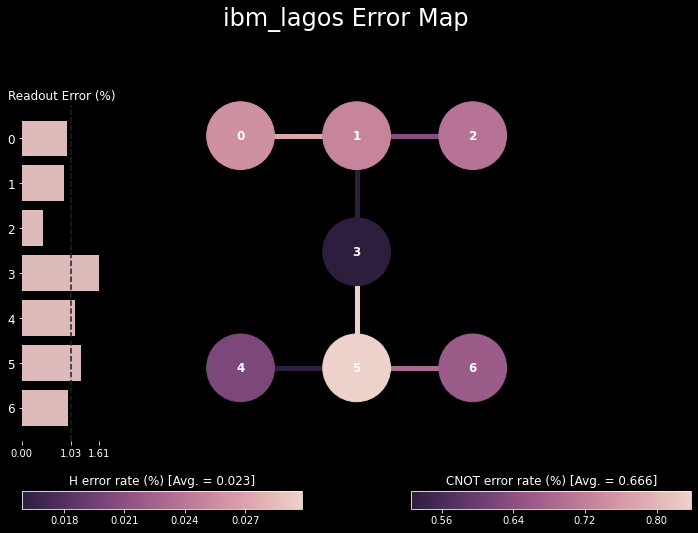

In [9]:
plot_error_map(backend)

In [10]:
qr = QuantumRegister(backend_config.num_qubits, 'q')
cr = ClassicalRegister(backend_config.num_qubits, 'c')
# initial_layout = [3, 5, 6] # runs 1-52
#initial_layout = [3, 1, 2] # runs 53-100, 103-135
#initial_layout = [2, 1, 0] # runs 136-192
#initial_layout = [4, 5, 6] # runs 101, 102
initial_layout = [6, 5, 4] # runs 192-
# initial_layout = [1, 2, 3] # testing on ibmq_bogota
native_gates = ['rz', 'sx', 'rzx', 'x']

In [11]:
avg_gate_error = 0
for ii in range(len(initial_layout)-1):
    q0 = initial_layout[ii]
    q1 = initial_layout[ii+1]
    avg_gate_error += backend.properties().gate_property('cx')[(q0, q1)]['gate_error'][0]

avg_gate_error /= len(initial_layout)-1
print('Avg 2-qubit gate error is '+str(avg_gate_error))

Avg 2-qubit gate error is 0.006065532619754954


## Template Optimization and Basic Transpilation

In [12]:
trot_circ1 = transpile(trot_circ, optimization_level=0)
pass_ = TemplateOptimization(**rzx_templates.rzx_templates()) 
trot_circ2 = PassManager(pass_).run(trot_circ1)
trot_circ3 = transpile(trot_circ2, basis_gates=native_gates,
                      backend=backend, initial_layout=initial_layout)
#trot_circ3.draw(output='mpl', idle_wires=False)

## Bespoke Transpilation Time

So far, just doing one to combine consecutive gates. Does not look like modulo $2\pi$ is necessary here.

### Combine Consectutive Gates Pass

In [13]:
def combine_runs(dag: DAGNode, gate_str: str) -> DAGCircuit:
    runs = dag.collect_runs([gate_str])
    for run in runs:
        partition = []
        chunk = []
        for ii in range(len(run)-1):
            chunk.append(run[ii])

            qargs0 = run[ii].qargs
            qargs1 = run[ii+1].qargs

            if qargs0 != qargs1:
                partition.append(chunk)
                chunk = []

        chunk.append(run[-1])
        partition.append(chunk)

        # simplify each chunk in the partition
        for chunk in partition:
            theta = 0
            for ii in range(len(chunk)):
                theta += chunk[ii].op.params[0]

            # set the first chunk to sum of params
            chunk[0].op.params[0] = theta

            # remove remaining chunks if any
            if len(chunk) > 1:
                for nn in chunk[1:]:
                    dag.remove_op_node(nn)
    return dag

### Run Bespoke Passes

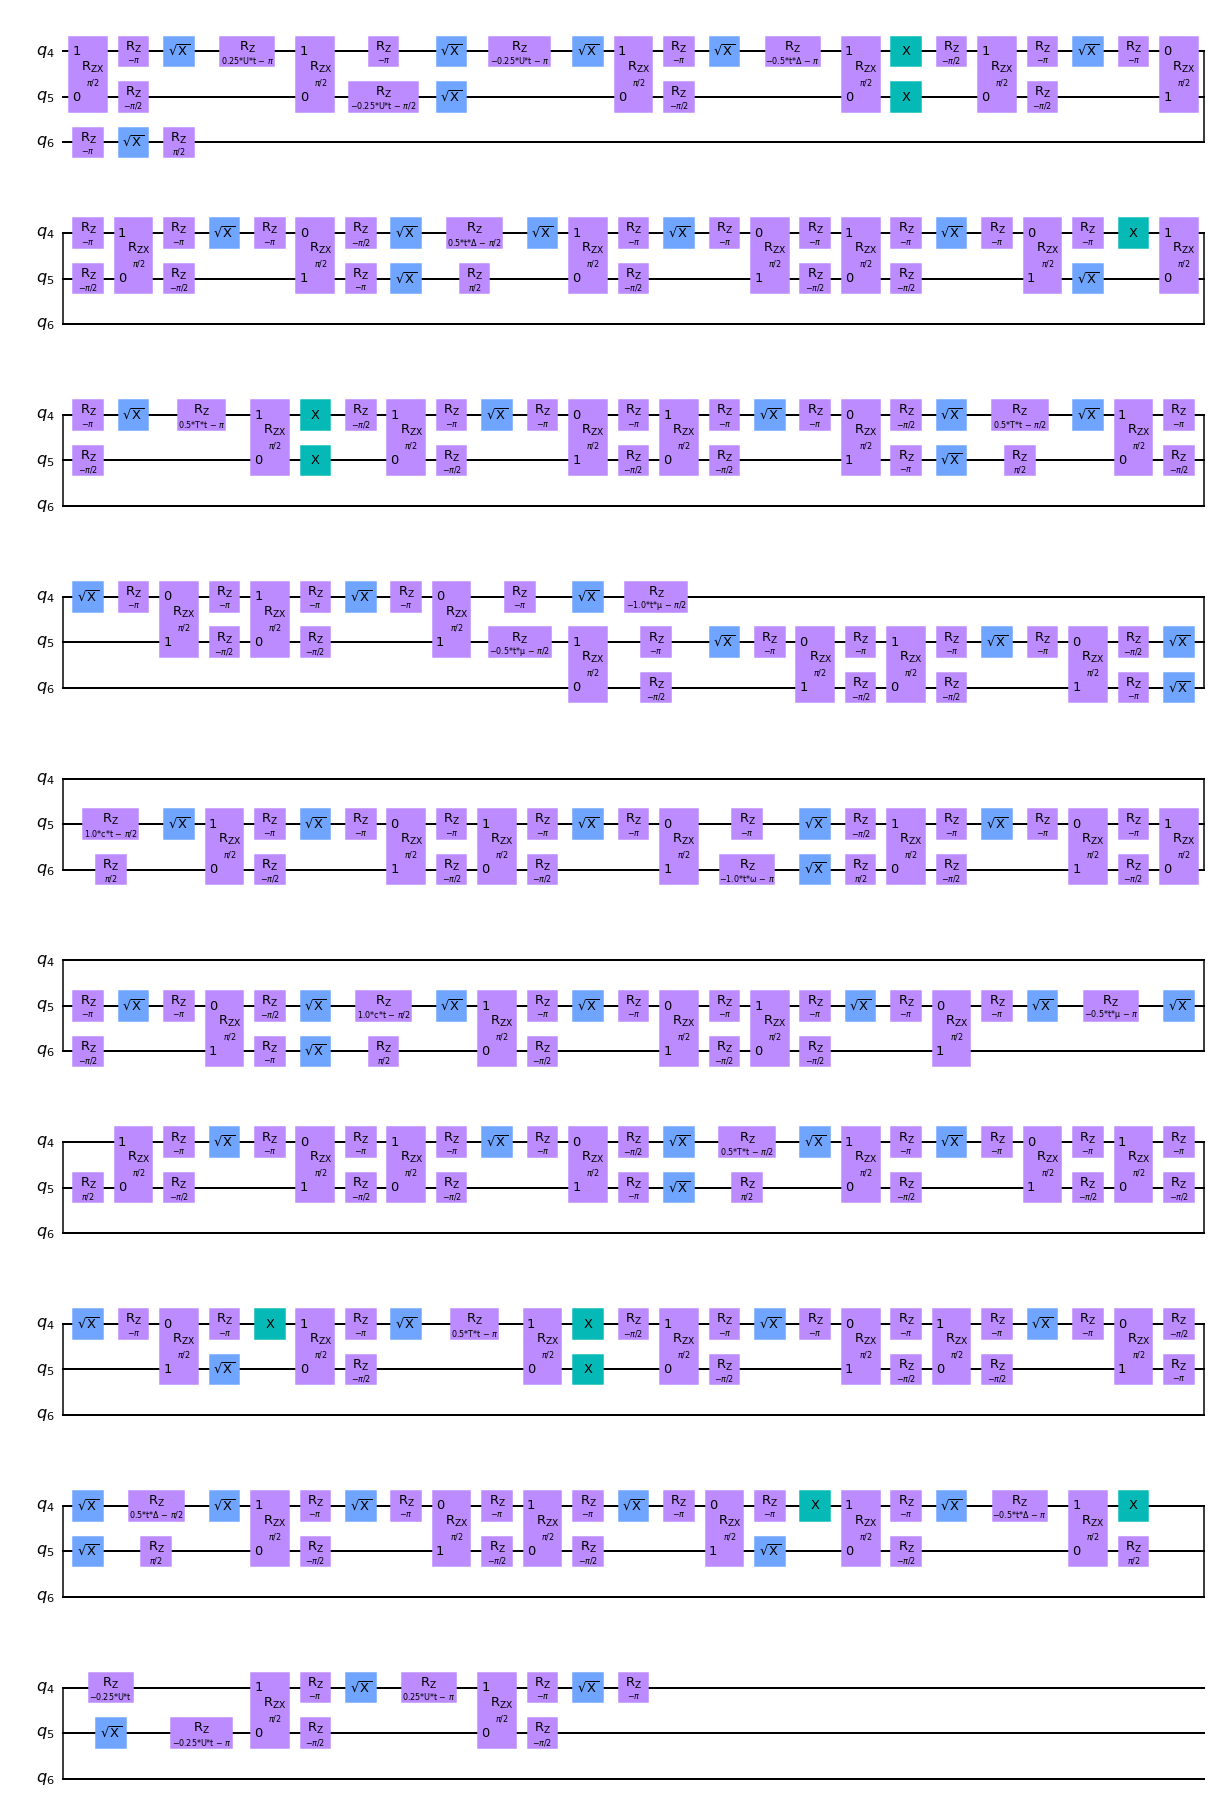

In [14]:
dag = circuit_to_dag(trot_circ3)
dag = combine_runs(dag, 'rz')
dag = combine_runs(dag, 'rzx')
trot_circ4 = dag_to_circuit(dag)
trot_circ4.draw(output='mpl', idle_wires=False)

## Game Plan
The above circuit is as transpiled as possible without binding parameters and adding the calibrations for the `RZXGate`s. This will form the unit of the sweeps we run.

# Build Sweep Experiment

In [15]:
trot_unit = trot_circ4

exp_str = 'm_sweep' # or 't_sweep' or 'c_sweep' or 'y_sweep'

## Set Model Hamiltonian Parameters

Grouping by terms, the Model Hamiltonian is written as
$$
H_{\rm Pauli} = -\frac{2\mu + U}{4} (IZ + ZI) + \frac{t+\Delta}{2} XX + \frac{t-\Delta}{2} YY + \frac{U}{4} ZZ \\
\equiv m(IZ + IZ) + x XX + y YY + z ZZ
$$
negelecting the identity term. 

In [16]:
x_set = 1.5
# z_set = 0.2 # runs 1-4, 53-68, 209-224 (z semi-on!)
z_set = 0.0 # runs 5-20, 69-84, 101-103, 115-139, 225-240 (z off!)
# z_set = 0.4 # runs 21-52, 140-208, (z on!)
# z_set = -0.4 # runs 85-100 (z on and negative!)

### Invert Parameters before Binding

$$
t = x + y \qquad \Delta = x - y \qquad U = 4z \qquad \mu = -2(m+z)
$$

(This now happens differently in each param sweep step)

In [17]:
# job will choke on Parameter keys, convert to strings

def stringify(param_bind: dict) -> dict:
    param_bind_str = {}
    for key in param_bind.keys():
        param_bind_str[str(key)] = param_bind[key]
    
    return param_bind_str      

## Timing Sweep Experiment

### Set Remaining Parameters

In [18]:
if exp_str == 't_sweep':
    # runs 1-3
    #c_set = 0.4
    #m_set = 1.0
    #y_set = 0.4
    
    # run 115
    c_set = 0.3
    m_set = 0.1
    y_set = 0.1
    
    T_set = x_set + y_set
    D_set = x_set - y_set
    U_set = 4*z_set
    mu_set = -2*(m_set + z_set)
    
    param_bind = {TT: T_set, DD: D_set, UU: U_set, mu: mu_set, cc: c_set}

### Set Experimental Parameters

In [19]:
if exp_str == 't_sweep':
    # Create the range of t values
    #t0 = 1.0 # run 1
    #t0 = 4.0 # run 2
    #t0 = 3.0 # run 3
    #dt = 1.0
    #Nt = 3 # ntb - max num of circuits is 900 - runs 1, 2, 3
    #t_range = [ti*dt + t0 for ti in range(Nt)] 
    
    t_range = [1.0, 3.0, 5.0, 10.0] # run 115

    # Create the range of dt values
    dt_range = [0.1, 0.2, 0.5, 1.0] # runs 1, 2, 115
    #dt_range = [0.8, 1.2, 1.5, 2.0] # run 3

    # Create the range of w values
    # w0 = -3.7 # runs 1-3
    # w0 = -3.5
    # dw = 0.1
    # Nw = 75 # ntb - now 3*4*75 = 900, so we're good!
    # w_range = [wi*dw + w0 for wi in range(Nw)] 
    
    # run 115
    dw = 0.14
    w_range = np.linspace(-3.5, 3.5, 51)

### Bind Parameters and Append Circuits

In [20]:
if exp_str == 't_sweep':
    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for t_set in t_range:
        for dt_set in dt_range:
            # Now let's add the circuits together
            NT = int(t_set/dt_set)
            print(NT*dt_set,', ',t_set, ', ', dt_set)
            trot_circ_total = copy.deepcopy(trot_unit)
            for ti in range (1,NT):
                trot_circ_total.append(trot_unit, qr)
            param_bind[tt] = dt_set # KEEP THIS LINE
            for w_set in w_range:
                circ_str = 'Freq sweep w='+str(round(w_set, 2))+', '+str(round(NT, 3))+' Trotter steps (2nd order)'
                bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
                temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                           metadata=stringify({**param_bind, ww: w_set}))
                temp_circ.append(bound_circ, qr)
                temp_circ.measure(qr, cr)
                circ_w.append(temp_circ)
                param_decoder.append(['t=' + str(t_set) + ', dt=' + str(dt_set) + ', w=' + str(round(w_set,2))])

## $c$ Sweep Experiment

### Set Remaining Parameters

In [21]:
if exp_str == 'c_sweep':
    # t_set = 5.0 # job 4
    # dt_set = 1.2 # job 4
    # m_set = 1.0 # job 4
    # y_set = 0.4 # job 4
    
    t_set = 5.0 # jobs 101-103
    dt_set = 0.7 # jobs 101-103
    
    # m_set = 0.0 # job 101
    # y_set = 0.0 # job 101
    
    m_set = 0.1 # jobs 102, 103
    y_set = 0.1 # jobs 102, 103
    
    T_set = x_set + y_set
    D_set = x_set - y_set
    U_set = 4*z_set
    mu_set = -2*(m_set + z_set)

    param_bind = {TT: T_set, DD: D_set, UU: U_set, mu: mu_set, tt: dt_set}

### Set Experimental Parameters

In [22]:
if exp_str == 'c_sweep':
    
    # Create the range of c values
    #c0 = 0.1 # run 4
    c0 = 0.03 # runs 101-103
    #dc = 0.1 # run 4
    dc = 0.03 # runs 101-103
    Nc = 12
    #c_range = [ci*dc + c0 for ci in range(Nc)] runs 4, 101-103
    
    c_range = np.linspace(0.03, 0.06, 2) # run 123

    # Create the range of w values
    w0 = -3.7
    dw = 0.1
    Nw = 75 
    w_range = [wi*dw + w0 for wi in range(Nw)]

In [23]:
if exp_str == 'c_sweep':
    # Now let's add the circuits together
    NT = int(t_set/dt_set)
    trot_circ_total = copy.deepcopy(trot_unit)
    for ti in range (1,NT):
        trot_circ_total.append(trot_unit, qr)

    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for c_set in c_range:
        param_bind[cc] = c_set
        for w_set in w_range:
            circ_str = 'Freq sweep w='+str(round(w_set, 2))+', $c$ = '+str(round(c_set, 2))
            bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
            temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                       metadata=stringify({**param_bind, ww: w_set}))
            temp_circ.append(bound_circ, qr)
            temp_circ.measure(qr, cr)
            circ_w.append(temp_circ)
            param_decoder.append(['c=' + str(round(c_set, 2)) + ', w=' + str(round(w_set, 2))])

## $m$ Sweep Experiment

### Set Remaining Parameters

In [24]:
if exp_str == 'm_sweep':
    t_set = 5.0
    #dt_set = 1.2 # runs 5-36
    dt_set = 0.7 # runs 37-100, 140-194, 211-240
    #dt_set = 0.1 # runs 123-127
    c_set = 0.3
    
    # y_set = -1.5 # runs 5, 21, 37, 53, 69, 85, 140, 156, 173, 193, 209, 225
    # y_set = -1.3 # runs 6, 22, 38, 54, 70, 86, 141, 157, 172, 194, 210, 226
    # y_set = -1.1 # runs 7, 23, 39, 55, 71, 87, 142, 158, 195, 211, 227
    # y_set = -0.9 # runs 8, 24, 40, 56, 72, 88, 143, 159, 196, 212, 228
    # y_set = -0.7 # runs 9, 25, 41, 57, 73, 89, 144, 160, 197, 213, 229
    # y_set = -0.5 # runs 10, 26, 42, 58, 74, 90, 145, 161, 198, 214, 230
    # y_set = -0.3 # runs 11, 27, 43, 59,75, 91, 146, 162, 199, 215, 231
    # y_set = -0.1 # runs 12, 28, 44, 60, 76, 92, 147, 163, 200, 216, 232
    #y_set = 0.1 # runs 13, 29, 45, 61, 77, 93, 123, 148, 164, 201, 217, 233
    # y_set = 0.3 # runs 14, 30, 46, 62, 78, 94, 149, 165, 202, 218, 234
    # y_set = 0.5 # runs 15, 31, 47, 63, 79, 95, 150, 166, 203, 219, 235
    # y_set = 0.7 # runs 16, 32, 48, 64, 80, 96, 151, 167, 204, 220, 236
    # y_set = 0.9 # runs 17, 33, 49, 65, 81, 97, 152, 168, 205, 221, 237
    # y_set = 1.1 # runs 18, 34, 50, 66, 82, 98, 153, 169, 206, 222, 238
    # y_set = 1.3 # runs 19, 35, 51, 67, 83, 99, 154, 170, 207, 223, 239
    y_set = 1.5 # runs 20, 36, 52, 68, 84, 100, 155, 171, 208, 224, 240

    U_set = 4*z_set

    param_bind = {UU: U_set, tt: dt_set, cc: c_set}
    m_range = np.linspace(-1.5, 1.5, 16) # runs before 123, 140-
    # m_range = np.linspace(-0.1, 0.1, 3) # run 123
    w_range = np.linspace(-3.5, 3.5, 51)

In [25]:
if exp_str == 'm_sweep':
    # Now let's add the circuits together
    NT = int(t_set/dt_set)
    trot_circ_total = copy.deepcopy(trot_unit)
    for ti in range (1, NT):
        trot_circ_total.append(trot_unit, qr)

    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for m_set in m_range:
        mu_set = -2*(m_set + z_set)
        T_set = x_set + y_set
        D_set = x_set - y_set
        
        param_bind[mu] = mu_set
        param_bind[TT] = T_set
        param_bind[DD] = D_set
        for w_set in w_range:
            circ_str = 'Freq sweep w='+str(round(w_set, 2))+', $\mu$ = '+str(round(mu_set, 2))
            bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
            temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                       metadata=stringify({**param_bind, ww: w_set}))
            temp_circ.append(bound_circ, qr)
            #temp_circ.measure(qr, cr)
            temp_circ.measure(qr[initial_layout[0]], cr[initial_layout[0]]) # runs 136-
            circ_w.append(temp_circ)
            param_decoder.append(['y='+str(round(y_set, 2))+', m=' + str(round(m_set, 2)) + 
                                  ', w=' + str(round(w_set, 2))])

## $y$ Sweep Experiment

### Set Remaining Parameters

In [26]:
if exp_str == 'y_sweep':
    t_set = 5.0
    dt_set = 0.7 # runs 104-114, 128-140, 189-192
    #dt_set = 0.1 # runs 116-126
    c_set = 0.3
    m_set = 0.0 # runs 104-114, 116-122, 128
    
    # z_set = -0.5 # runs 104
    # z_set = -0.4 # runs 105
    # z_set = -0.3 # runs 106
    # z_set = -0.2 # runs 107
    # z_set = -0.1 # runs 108
    # z_set = 0.0 # runs 109, 116-121, 128
    # z_set = 0.1 # runs 110
    # z_set = 0.2 # runs 111
    # z_set = 0.3 # runs 112
    # z_set = 0.4 # runs 113
    # z_set = 0.5 # runs 114
    
    mu_set = -2*(m_set + z_set)
    U_set = 4*z_set
    
    param_bind = {mu: mu_set, UU: U_set, tt: dt_set, cc: c_set}
    
    #y_range = np.linspace(-1.5, 1.5, 16) # runs 104-114
    
    #y_range = np.linspace(-1.5, -1.3, 2) # run 116 (4 scans?), 122
    #y_range = np.linspace(-1.1, -0.7, 3) # run 117
    #y_range = np.linspace(-0.5, -0.1, 3) # run 118
    #y_range = np.linspace(0.1, 0.5, 3) # run 119
    #y_range = np.linspace(0.7, 1.1, 3) # run 120
    #y_range = np.linspace(1.3, 1.5, 2) # run 121
    
    #y_range = [-1.5] # run 128 (fail)
    #y_range = np.linspace(-1.5, -0.7, 5) # run 128
    #y_range = np.linspace(-0.5, 0.3, 5) # run 129
    #y_range = np.linspace(0.5, 1.3, 5) # run 130
    #y_range = np.linspace(1.5, 1.5, 1) # run 131
    
    #y_range = np.linspace(-1.5, -0.9, 4) # runs 132, 136, 189
    #y_range = np.linspace(-0.7, -0.1, 4) # runs 133, 137, 190
    #y_range = np.linspace(0.1, 0.7, 4) # runs 134, 191
    y_range = np.linspace(0.9, 1.5, 4) # runs 135, 192
    
    w_range = np.linspace(-3.5, 3.5, 51)

In [27]:
if exp_str == 'y_sweep':
    # Now let's add the circuits together
    NT = int(t_set/dt_set)
    trot_circ_total = copy.deepcopy(trot_unit)
    for ti in range (1, NT):
        trot_circ_total.append(trot_unit, qr)

    #Bind the parameters 
    circ_w = []
    param_decoder = []
    for y_set in y_range:
        T_set = x_set + y_set
        D_set = x_set - y_set
        
        param_bind[TT] = T_set
        param_bind[DD] = D_set
        for w_set in w_range:
            circ_str = 'Freq sweep w='+str(round(w_set, 2))+', $z$ = '+str(round(z_set, 2))
            bound_circ = trot_circ_total.bind_parameters({**param_bind, ww: w_set})
            temp_circ = QuantumCircuit(qr, cr, name=circ_str, 
                                       metadata=stringify({**param_bind, ww: w_set}))
            temp_circ.append(bound_circ, qr)
            #temp_circ.measure(qr, cr) # runs pre-135
            temp_circ.measure(qr[initial_layout[0]], cr[initial_layout[0]]) # runs 136-
            circ_w.append(temp_circ)
            param_decoder.append(['y='+str(round(y_set, 2))+', z=' + str(round(z_set, 2)) + 
                                  ', w=' + str(round(w_set, 2))])

## Final Transpilation Steps

In [28]:
res_circ_scaled_trans = transpile(circ_w, backend, basis_gates=native_gates)
res_circ_digital_trans = transpile(circ_w, backend)

In [29]:
pass_ = RZXCalibrationBuilder(backend)
res_circ_scaled_trans1 = PassManager(pass_).run(res_circ_scaled_trans)

## Dynamical Decoupling

Following [this tutorial](https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.DynamicalDecoupling.html), we can automatically add dynamical decoupling sequences. Currently this seems a bit limited to "native" Qiskit gates, and the duration information must be pulled from the `inst_sched_map`. <br>

**Note:** We did not find any improvement in the results with dynamical decoupling, and all the data presented in the manuscript is without it. We are continuing to investigate why this is the case.

In [30]:
if dynamical_decoupling:
    inst_durs = []

    # single qubit gates
    for qubit in range(backend_config.num_qubits):
        for inst_str in inst_sched_map.qubit_instructions(qubits=[qubit]):
            inst = inst_sched_map.get(inst_str, qubits=[qubit])
            inst_durs.append((inst_str, qubit, inst.duration))
            if inst_str == 'x':
                inst_durs.append(('y', qubit, inst.duration))

    # two qubit gates
    for qc in range(backend_config.num_qubits):
        for qt in range(backend_config.num_qubits):
            for inst_str in inst_sched_map.qubit_instructions(qubits=[qc, qt]):
                inst = inst_sched_map.get(inst_str, qubits=[qc, qt])
                inst_durs.append((inst_str, [qc, qt], inst.duration))
                #inst_durs.append(('rzx', [qc, qt], inst.duration)) # TOTALLY FAKING IT

    durations = InstructionDurations(inst_durs)

In [31]:
if dynamical_decoupling:
    # balanced X-X sequence on all qubits
    dd_x2_sequence = [XGate(), XGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, dd_x2_sequence)])
    res_circ_ddx2 = pm.run(res_circ_scaled_trans1)

In [32]:
if dynamical_decoupling:
    dd_xy4_sequence = [XGate(), YGate(), XGate(), YGate()]
    pm = PassManager([ALAPSchedule(durations),
                      DynamicalDecoupling(durations, dd_xy4_sequence)])
    res_circ_ddxy4 = pm.run(res_circ_scaled_trans1)

In [33]:
if dynamical_decoupling:
    start_time = 0 #880000
    time_window = 20000
    time_range=[start_time, start_time+time_window]
    timeline_drawer(res_circ_ddxy4[-1], time_range=time_range)

In [34]:
if dynamical_decoupling:
    pm = PassManager(ALAPSchedule(durations))
    res_circ_nodd = pm.run(res_circ_scaled_trans1)
    #timeline_drawer(res_circ_nodd[-1], time_range=time_range)
    res_circ_scaled_trans1[-1].draw(idle_wires=False)

### Add Calibrations for Missing Gates

The`YGate` is not a basis gate of our backend (unlike 'x'). We can build a pulse schedule from 'x' and add it to the circuits.

In [35]:
if dynamical_decoupling:
    for qubit in range(backend_config.num_qubits):
        with pulse.build('y gate for qubit '+str(qubit)) as sched:
            with pulse.phase_offset(np.pi/2, DriveChannel(qubit)):
                x_gate = inst_sched_map.get('x', qubits=[qubit])
                pulse.call(x_gate)

            for circ in res_circ_ddxy4:
                circ.add_calibration('y', [qubit], sched)


## Compare digital and scaled circuits

In [36]:
circ_num = -1
scaled_sched = schedule(res_circ_scaled_trans1[circ_num], backend)
basis_sched = schedule(res_circ_digital_trans[circ_num], backend)

### Count Operations

In [37]:
res_circ_scaled_trans1[circ_num].count_ops()

OrderedDict([('rz', 1127),
             ('rzx', 420),
             ('sx', 406),
             ('x', 70),
             ('measure', 1)])

In [38]:
res_circ_digital_trans[circ_num].count_ops()

OrderedDict([('rz', 1406),
             ('cx', 840),
             ('sx', 773),
             ('x', 42),
             ('measure', 1)])

In [39]:
dag = circuit_to_dag(res_circ_scaled_trans1[circ_num])
rzx_runs = dag.collect_runs(['rzx'])

est_fid_rzx = 1
for rzx_run in rzx_runs:
    angle = rzx_run[0].op.params[0]
    this_rzx_error = (abs(float(angle))/(np.pi/2))*avg_gate_error
    est_fid_rzx *= (1-this_rzx_error)
    
print('Scaled Circuit estimated fidelity is %2.f%%' % (est_fid_rzx*100))

Scaled Circuit estimated fidelity is  8%


In [40]:
num_cx = res_circ_digital_trans[circ_num].count_ops()['cx']
est_fid_dig = (1-avg_gate_error)**num_cx
print('Digital Circuit estimated fidelity is %2.f%%' % (est_fid_dig*100))

Digital Circuit estimated fidelity is  1%


### Look at Resulting Schedules

In [41]:
print('Scaled schedule takes '+str(scaled_sched.duration)+'dt')
print('Digital schedule takes '+str(basis_sched.duration)+'dt')

Scaled schedule takes 694400dt
Digital schedule takes 1290560dt


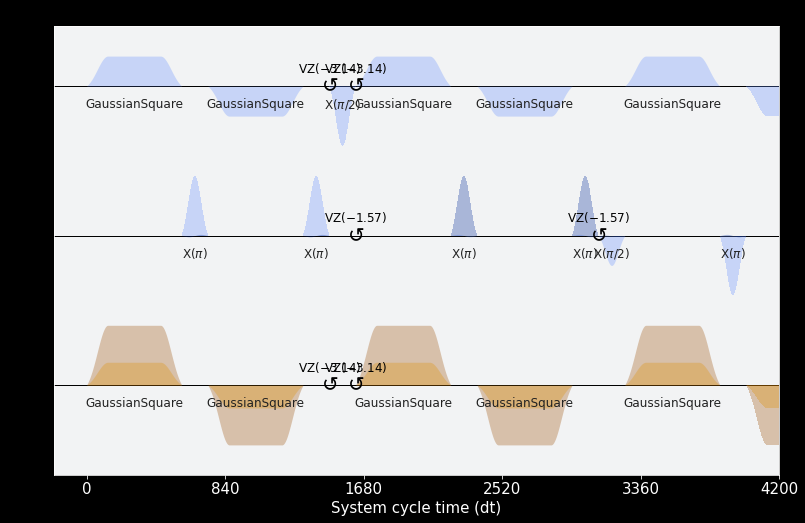

In [42]:
time_range=[0,4000]
scaled_sched.draw(time_range=time_range)

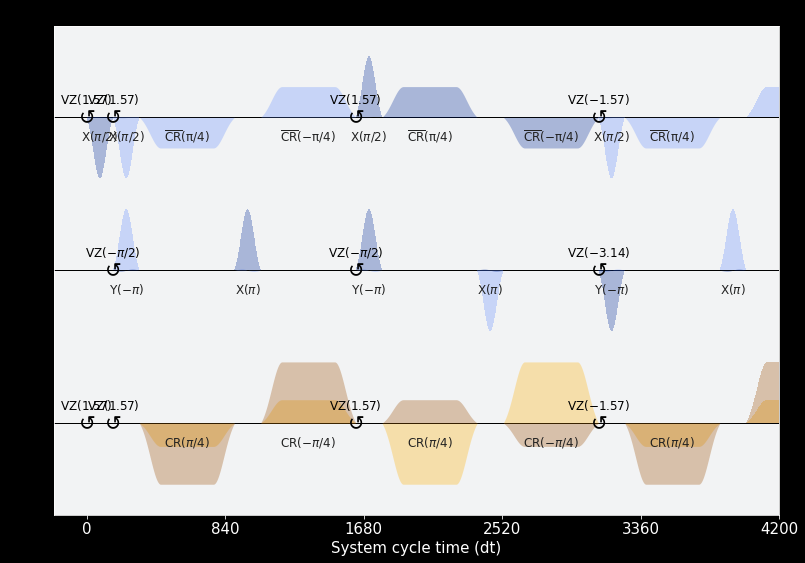

In [43]:
basis_sched.draw(time_range=time_range)

# Run on Quantum Hardware

In [44]:
from qiskit.tools.monitor import job_monitor

if run_experiment:
    # run the job on a real backend
    if dynamical_decoupling:
        job = backend.run(res_circ_scaled_trans1 + res_circ_ddx2 + res_circ_ddxy4, 
                          job_name="SE_Eigensolver", meas_level=2, shots=8192)
    else:
        job = backend.run(res_circ_scaled_trans1, job_name="SE_Eigensolver", meas_level=2, shots=8192) 

    
    print(job.job_id())
    job_monitor(job)

## Or Retrieve from Previous Run

In [45]:
if not run_experiment:
    # ntb default internal provider job ids
    job_ids_def = [
                  # y=0.4, m=1.0, c=0.4, z=0.2
                   '6134d974f8e62dc8e4a7bfed', # run 1 - t_sweep
                   '614141d26feb7e1aa36f5656', # run 2 - t_sweep
                   '6143af378eca75f46d42c806', # run 3 - t_sweep
                   '615097d12e79b36819d35e6e', # run 4 - c_sweep 
                   
                  # z=0 runs (off)
                   '615b59fcc97866325c08ff55', # run 5 - m_sweep, y=-1.5
                   '615b684a20df542ec45e3b52', # run 6 - m_sweep, y=-1.3
                   '615bc81720df5465eb5e400b', # run 7 - m_sweep, y=-1.1
                   '615bd258837ee41079c253b0', # run 8 - m_sweep, y=-0.9
                   '615bddb29f1b4a43d4ff7cd7', # run 9 - m_sweep, y=-0.7
                   '615be885da98d568592b90b5', # run 10 - m_sweep, y=-0.5
                   '615c8914837ee44fb3c259da', # run 11 - m_sweep, y=-0.3
                   '6160cd020fa7c30e31a26fce', # run 12 - m_sweep, y=-0.1
                   '6160da990fa7c32ddaa27035', # run 13 - m_sweep, y=0.3
                   '61617706d35e28a5db93d21f', # run 14 - m_sweep, y=0.3
                   '61618cd7d35e2800b793d284', # run 15 - m_sweep, y=0.5
                   '616236bfc978666c46093276', # run 16 - m_sweep, y=0.7
                   '6162ae9cfc7bdf39a143e79e', # run 17 - m_sweep, y=0.9
                   '6164ba8d9f1b4a48b0ffbb66', # run 18 - m_sweep, y=1.1
                   '6164c762ed29dd5a5ec69776', # run 19 - m_sweep, y=1.3
                   '616544f2ed29dd485fc69b9f', # run 20 - m_sweep, y=1.5
    
                  # z=0.4 runs (on)
                   '616ac829e4cd1779b14b3ddb', # run 21 - m_sweep, y=-1.5
                   '616c03c682ec5a4008ddfb88', # run 22 - m_sweep, y=-1.3
                   '616ca052540eb274f628c895', # run 23 - m_sweep, y=-1.1
                   '616d48d3f21fcaeb037754fe', # run 24 - m_sweep, y=-0.9
                   '61701ccc9c88ce3e40b0e94b', # run 25 - m_sweep, y=-0.7
                   '617028da43727303b3987d8a', # run 26 - m_sweep, y=-0.5
                   '6170427a7c5dd5042afd2c3a', # run 27 - m_sweep, y=-0.3, re-started notebook (updated inst_sched_map)
                   '61704eee78399c3a6550430f', # run 28 - m_sweep, y=-0.1
                   '61705b16437273463f987ead', # run 29 - m_sweep, y=0.1
                   '617069ac437273c21e987efc', # run 30 - m_sweep, y=0.3
                   '617078907c5dd5d51ffd2d72', # run 31 - m_sweep, y=0.5
                   '617083b8ac4af566ce5a704b', # run 32 - m_sweep, y=0.7
                   '61708ee9dd30e9613de61df5', # run 33 - m_sweep, y=0.9
                   '6170cf1ccea63368481457e1', # run 34 - m_sweep, y=1.1
                   '617147fe9c88ce1f75b0ef87', # run 35 - m_sweep, y=1.3
                   '617157191cc68170e998717c', # run 36 - m_sweep, y=1.5
    
                  # z=0.4, dt_set=0.7
                   '6178374b2e5f445f3fcb2658', # run 37 - m_sweep, y=-1.5
                   '617844fb6ba9a855d003dd4a', # run 38 - m_sweep, y=-1.3
                   '61785e03ece07e62c10ebed1', # run 39 - m_sweep, y=-1.1
                   '61786f8b1286f275b142184a', # run 40 - m_sweep, y=-0.9
                   '61787dd656f4d7fe0d46ae76', # run 41 - m_sweep, y=-0.7
                   '6178a2cf0080172e4b4f2918', # run 42 - m_sweep, y=-0.5
                   '6178aeb5ece07e97770ec24d', # run 43 - m_sweep, y=-0.3
                   '6178bbfc11395bfd151c4d86', # run 44 - m_sweep, y=-0.1
                   '6178c9b156f4d7233046b19c', # run 45 - m_sweep, y=0.1
                   '6178d75eece07e3d5a0ec4b2', # run 46 - m_sweep, y=0.3
                   '61793cd476b55a37f0afb0c8', # run 47 - m_sweep, y=0.5
                   '6179493ab851bf00930d20fc', # run 48 - m_sweep, y=0.7
                   '617957222e5f4451cfcb33de', # run 49 - m_sweep, y=0.9
                   '61797e0119bc9c65ec82fc1f', # run 50 - m_sweep, y=1.1
                   '6179926abc9884d8485f8cf4', # run 51 - m_sweep, y=1.3
                   '6179b31c19bc9c08b482fd8d'] # run 52 - m_sweep, y=1.5
    
    # z=0.2, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
    job_ids_crit = ['618c1c4518014be18ad2adbe', # run 53 - m_sweep, y=-1.5
                    '618c2c8efa93429c778ac41f', # run 54 - m_sweep, y=-1.3
                    '618c4115fa934243108ac4d1', # run 55 - m_sweep, y=-1.1
                    '618c7e3afa93425ec58ac643', # run 56 - m_sweep, y=-0.9
                    '618c848d3b109c0483477918', # run 57 - m_sweep, y=-0.7
                    '618c86a72ab8f59ab6622e61', # run 58 - m_sweep, y=-0.5
                    '618c893218014b4609d2b0d4', # run 59 - m_sweep, y=-0.3
                    '618c8b8b18014b5b2fd2b0e6', # run 60 - m_sweep, y=-0.1
                    '618c8dee9880afc3cdc0ffe5', # run 61 - m_sweep, y=0.1
                    '618c900748856a0f34edafbb', # run 62 - m_sweep, y=0.3
                    '618c923d3b109c1c1547794f', # run 63 - m_sweep, y=0.5
                    '618c95a8fa934200318ac6ba', # run 64 - m_sweep, y=0.7
                    '618c97e99880af1fe9c10012', # run 65 - m_sweep, y=0.9
                    '618c9a06e6cb0990eb6353cd', # run 66 - m_sweep, y=1.1
                    '618c9ce58b10e72e3968d4f6', # run 67 - m_sweep, y=1.3
                    '618c9f5318014b7af8d2b134', # run 68 - m_sweep, y=1.5
    
                  # z=0.0, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '618d1e98fc46da9adb8e449f', # run 69 - m_sweep, y=-1.5
                    '618d21a60b2c123cdd6fe67a', # run 70 - m_sweep, y=-1.3
                    '618d23b9944d5dfd6baa7c0e', # run 71 - m_sweep, y=-1.1
                    '618d3abb2b0346846de1044e', # run 72 - m_sweep, y=-0.9
                    '618d3ebdfc46da52818e45da', # run 73 - m_sweep, y=-0.7
                    '618d41eb1fe02d691ac3c150', # run 74 - m_sweep, y=-0.5
                    '618d4420fc46da7e578e460d', # run 75 - m_sweep, y=-0.3
                    '618d476f9c22c361d6e5edfb', # run 76 - m_sweep, y=-0.1
                    '618d49f06bc1dd0e0093df68', # run 77 - m_sweep, y=0.1
                    '618d5584cc669a3eb2d2db45', # run 78 - m_sweep, y=0.3
                    '618d704c56c9100e1e703eca', # run 79 - m_sweep, y=0.5
                    '618d74390b2c125d2a6feacc', # run 80 - m_sweep, y=0.7
                    '618d76829c22c34cb9e5f125', # run 81 - m_sweep, y=0.9
                    '618d78ea944d5d4b95aa809e', # run 82 - m_sweep, y=1.1
                    '618d7b482b03466eb3e107e2', # run 83 - m_sweep, y=1.3
                    '618d7f5ccc669a7f15d2de36', # run 84 - m_sweep, y=1.5
    
                  # z=-0.4, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '6193fa73e2f5b6eaf668bb81', # run 85 - m_sweep, y=-1.5
                    '619400b1329f0fcecb48ff9b', # run 86 - m_sweep, y=-1.3
                    '619403696254ddbb65864dc3', # run 87 - m_sweep, y=-1.1
                    '61940b3bbd3c6c8facf93d9e', # run 88 - m_sweep, y=-0.9
                    '61940e982be06d53e3031457', # run 89 - m_sweep, y=-0.7
                    '619416e39d052aedb08b60e2', # run 90 - m_sweep, y=-0.5
                    '61942bed2be06d747b031563', # run 91 - m_sweep, y=-0.3
                    '61942e89a90bff28ea2618fc', # run 92 - m_sweep, y=-0.1
                    '6194360a9e1846348bb66019', # run 93 - m_sweep, y=0.1
                    '619438f6bd3c6cabc9f93f4f', # run 94 - m_sweep, y=0.3
                    '61943bd6972490e25893ad03', # run 95 - m_sweep, y=0.5
                    '61943ffd9d052a5ed18b6259', # run 96 - m_sweep, y=0.7
                    '61944665972490be1293ada1', # run 97 - m_sweep, y=0.9
                    '61944bc39e1846f279b6613c', # run 98 - m_sweep, y=1.1
                    '61944f60329f0ffd774902c5', # run 99 - m_sweep, y=1.3
                    '619464f49d052ab2ff8b6410', # run 100 - m_sweep, y=1.5
    
                  # z=0.0, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 4-5-6
                    '6195e4699e1846f410b66ceb', # run 101 - c_sweep, y=0, m=0
                    '61967f1e972490061893bc00', # run 102 - c_sweep, y=0.1, m=0.1
    
                  # z=0.0, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '61993d388b720eaf9c115002', # run 103 - c_sweep, y=0.1, m=0.1
    
                  # m=0.0, c=0.3, dt_set=0.7 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '61995d1e68476d66ef8a7d2a', # run 104 - y_sweep, z=-0.5
                    '619962005297baad34ecbbec', # run 105 - y_sweep, z=-0.4
                    '61996585cd37f3a2a3f268c9', # run 106 - y_sweep, z=-0.3
                    '61996851580e75146a14e9ad', # run 107 - y_sweep, z=-0.2
                    '61996b0a580e756af214e9be', # run 108 - y_sweep, z=-0.1
                    '619972508b720ead5e115124', # run 109 - y_sweep, z=0.0
                    '619975becd37f37687f2692b', # run 110 - y_sweep, z=0.1
                    '61997dbbcd37f39f02f2694c', # run 111 - y_sweep, z=0.2
                    '6199821a5297ba3f51ecbc9f', # run 112 - y_sweep, z=0.3
                    '619985648982d9e42f33858a', # run 113 - y_sweep, z=0.4
                    '61998a1d68476d08438a7e2a', # run 114 - y_sweep, z=0.5
    
                  # y=0.1, m=0.1, c=0.3 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '619e85ed580e756b62150f3c', # run 115 - t_sweep, z=0.0
    
                  # m=0.0, c=0.3, dt_set=0.1, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                  # z=0.0, noDD + X2 + XY4
                    '61a3f4805ddc02a92fe74b35', #run 116 - y_sweep -1.5 to -1.3
                    '61a3f8efe76c00841afa3e18', # run 117 - y_sweep -1.1 to -0.7
                    '61a3fd32fd3a881c19590d7e', # run 118 - y_sweep -0.5 to -0.1
                    '61a405cecbd50667abff0919', # run 119 - y_sweep 0.1 to 0.5
                    '61a4098683753d300027c668', # run 120 - y_sweep 0.7 to 1.1
                    '61a40c0fe76c00304afa3e68', # run 121 - y_sweep 1.3 to 1.5
                    '61a553a46a8ec04f82197eba', # run 122 - y_sweep redo -1.5 to -1.3
    
                  # z=0.0, c=0.3, dt_set=0.1, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2
                    '61a67b4a44185e542416c37b', # run 123 - m_sweep, y=0.1, m=-0.1, 0, 0.1
                    '61a9313ceeb4d473cdb075f2', # run 124 - m_sweep, y=0.1, m=-0.1, 0, 0.1 noDD passes
                    
                  # runs 125-127 failed due to backend job dispatcher issue, which continues for a few runs below
                    '', # run 125
                    '', # run 126
                    '', # run 127
                    
                  # m=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2 (redo)
                  # z=0.0, noDD + X2 + XY4
                    '61b38d11a43b0c79052af305', # run 128 - y_sweep -1.5 to -0.7
                    '61b9125b58158fc29bb6588f', # run 129 y_sweep -0.5 to 0.3 - CANCELED AFTER RUNNING 6 DAYS
                    '61b9287315ab795582b85d7e', # run 130 - y_sweep 0.5 to 1.3 - CANCELED AFTER RUNNING 6 DAYS
                    '61b64cdf33cebdd08a2b14d5', # run 131 - y_sweep 1.5 
    
                  # m=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2 (redo again)
                  # z=0.0, noDD + X2 + XY4
                    '61c36c8c06d47f3210c40853', # run 132 - y_sweep -1.5 to -0.9
                    '61c36db681db3e6e0084ef5b', # run 133 - y_sweep -0.7 to -0.1
                    '61c36e9be2b9d14fdc91222f', # run 134 - y_sweep 0.1 to 0.7
                    '61c370b006d47fa445c40867', # run 135 - y_sweep 0.9 to 1.5
                    
                  # m=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 3-1-2 (redo)
                  # z=0.0, noDD + X2 + XY4  
                  # redo again with just ancilla probe measurement, qubits 2-1-0
                    '61c49b445763548ad5f4fece', # run 136 - y_sweep -1.5 to -0.9
                    '61c49f5481db3ef02884f4b7', # run 137 - y_sweep -0.7 to -0.1
                    '61c4a0eb06d47f2b8ac40dac', # run 138 - y_sweep 0.1 to 0.7
                    '61c4a3b9576354c6d5f4feed', # run 139 - y_sweep 0.9 to 1.5
    
                  #z=0.4, dt_set=0.7, no DD, (NOT) single meas - MISSION CRITICAL PROVIDER, qubits 2-1-0
                  #THESE JOBS DO NOT SEEM TO BE BUILT CORRECTLY (153 circuits each?)
                    '61c64cb23b6df90e4273d848', # run 140 - m_sweep, y=-1.5
                    '61c64ded06d47fc247c4150d', # run 141 - m_sweep, y=-1.3
                    '61c64e9f255d4eff69d65400', # run 142 - m_sweep, y=-1.1
                    '61c64f3ba81fcf70ddd1cdf4', # run 143 - m_sweep, y=-0.9
                    '61c65110255d4e6242d6540c', # run 144 - m_sweep, y=-0.7
                    '61c651ad20e2c478beeaed2c', # run 145 - m_sweep, y=-0.5
                    '61c65269a81fcfba19d1cdf8', # run 146 - m_sweep, y=-0.3
                    '61c6530a06d47f71a6c4151f', # run 147 - m_sweep, y=-0.1
                    '61c653a3525f9ebfcd396399', # run 148 - m_sweep, y=0.1
                    '61c654c406d47f3f24c41521', # run 149 - m_sweep, y=0.3
                    '61c655a2e2b9d14243912f2e', # run 150 - m_sweep, y=0.5
                    '61c65773576354ecaff5064f', # run 151 - m_sweep, y=0.7
                    '61c6582a3b6df944a773d866', # run 152 - m_sweep, y=0.9
                    '61c658cf3b6df90a2273d868', # run 153 - m_sweep, y=1.1
                    '61c6598c3b6df9468c73d86e', # run 154 - m_sweep, y=1.3
                    '61c65a33a81fcf62cad1ce15', # run 155 - m_sweep, y=1.5
    
                  #z=0.4, dt_set=0.7, no DD, single meas - MISSION CRITICAL PROVIDER, qubits 2-1-0
                    '61c88da5525f9e6c03396cfd', # run 156 - m_sweep, y=-1.5
                    '61c88fa23b6df9efaf73e1c5', # run 157 - m_sweep, y=-1.3 - CANCELED
                    '61c8919406d47f0c22c41e62', # run 158 - m_sweep, y=-1.1 - CANCELED
                    '61c89388fa27f6330437cd8e', # run 159 - m_sweep, y=-0.9 - CANCELED
                    '61c895725763546712f50fa7', # run 160 - m_sweep, y=-0.7 - CANCELED
                    '61c8976d525f9e0b22396d24', # run 161 - m_sweep, y=-0.5 - CANCELED
                    '61c89ac5255d4ea33ad65d8e', # run 162 - m_sweep, y=-0.3
                    '61c8c63781db3e3f2a8507a5', # run 163 - m_sweep, y=-0.1 - CANCELED
                    '61c8c8cfa81fcfbefcd1d842', # run 164 - m_sweep, y=0.1 - CANCELED
                    '61c8cae206d47fe1f1c41f6f', # run 165 - m_sweep, y=0.3 - CANCELED
                    '61c908653b6df96f9373e37f', # run 166 - m_sweep, y=0.5 - CANCELED
                    '61c90b2ea81fcf35bed1d91a', # run 167 - m_sweep, y=0.7 - CANCELED
                    '61c90d4a06d47f111ac42049', # run 168 - m_sweep, y=0.9 - CANCELED
                    '61c90f6606d47f3563c4204e', # run 169 - m_sweep, y=1.1 - CANCELED
                    '61c9116581db3ef39b8508ce', # run 170 - m_sweep, y=1.3 - CANCELED
                    '61c9135cfa27f68c3b37cf52', # run 171 - m_sweep, y=1.5 - CANCELED
    
                  #z=0.4, dt_set=0.7, no DD, single meas - MISSION CRITICAL PROVIDER, qubits 2-1-0
                    '61ca03c13b6df9a02173e6d0', # run 172 - m_sweep, y=-1.3 retry - CANCELED
                    '61cb5c3ae2b9d1816c914240', # run 173 - m_sweep, y=-1.5 - CANCELED
                  # runs 174-188 never executed due to dispatcher issues
                    '', # run 174
                    '', # run 175
                    '', # run 176
                    '', # run 177
                    '', # run 178
                    '', # run 179
                    '', # run 180
                    '', # run 181
                    '', # run 182
                    '', # run 183
                    '', # run 184
                    '', # run 185
                    '', # run 186
                    '', # run 187
                    '', # run 188

                  # m=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 2-1-0
                  # z=0.4, noDD + X2 + XY4, fixed rzx timing issue (which may have effected DD)
                    '61ce04e4fa27f692da37e282', # run 189 - y_sweep -1.5 to -0.9
                    '61d48634a81fcf85c2d1fe42', # run 190 - y_sweep -0.7 to -0.1
                    '61d488f4a81fcf9048d1fe48', # run 191 - y_sweep 0.1 to 0.7
                    '61d48e3bf24655412c32188f', # run 192- y_sweep 0.9 to 1.5

                  # z=0.4, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 6-5-4
                    '61dd84f58cd5fc403e46aa02', # run 193 - m_sweep, y=-1.5
                    '61dd877c8df39446a733150c', # run 194 - m_sweep, y=-1.3
                    '61dd89899307b9d55c6bc734', # run 195 - m_sweep, y=-1.1
                    '61dd8bfbfde78bdc64dbb70f', # run 196 - m_sweep, y=-0.9
                    '61dd8eb687d4f81a1f23fbd6', # run 197 - m_sweep, y=-0.7
                    '61dd91c08df394771c331547', # run 198 - m_sweep, y=-0.5
                    '61ddc35c8cd5fc172746aafa', # run 199 - m_sweep, y=-0.3
                    '61ddc5e00a744aba1199d15e', # run 200 - m_sweep, y=-0.1
                    '61ddc8ec9710ff9796ddf232', # run 201 - m_sweep, y=0.1
                    '61ddcb199307b947326bc854', # run 202 - m_sweep, y=0.3
                    '61ddcde49307b90c806bc85f', # run 203 - m_sweep, y=0.5
                    '61ddd08d6d650863301a1d7a', # run 204 - m_sweep, y=0.7
                    '61ddd2e46d6508358d1a1d8a', # run 205 - m_sweep, y=0.9
                    '61ddd50d87d4f8c4b923fcf3', # run 206 - m_sweep, y=1.1
                    '61dde83a6d65083ff41a1e1a', # run 207 - m_sweep, y=1.3
                    '61ddeb370a744a647299d24a', # run 208 - m_sweep, y=1.5
    
                  # z=0.2, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 6-5-4
                    '61df2a3a9710ff287dddf6ff', # run 209 - m_sweep, y=-1.5
                    '61df2dd4d1eb07e0264932f5', # run 210 - m_sweep, y=-1.3
                    '61df316dfde78b7054dbbcc6', # run 211 - m_sweep, y=-1.1
                    '61df3a7787d4f8eba8240171', # run 212 - m_sweep, y=-0.9
                    '61df3d00d1eb0724ae49330f', # run 213 - m_sweep, y=-0.7
                    '61df51809710ff7051ddf73f', # run 214 - m_sweep, y=-0.5
                    '61df5566fde78b1e13dbbd16', # run 215 - m_sweep, y=-0.3
                    '61df584487d4f8165c2401a3', # run 216 - m_sweep, y=-0.1
                    '61df5b3b0a744a90ea99d659', # run 217 - m_sweep, y=0.1
                    '61df5dbf9307b9f11f6bcd4d', # run 218 - m_sweep, y=0.3
                    '61df61dd8df3946094331b14', # run 219 - m_sweep, y=0.5
                    '61df65b00a744a5f9399d682', # run 220 - m_sweep, y=0.7
                    '61df685cd1eb07f6b0493371', # run 221 - m_sweep, y=0.9
                    '61df6add8df39466d9331b27', # run 222 - m_sweep, y=1.1
                    '61df6e7d87d4f82c802401d5', # run 223 - m_sweep, y=1.3
                    '61df71e89307b908636bcd79', # run 224 - m_sweep, y=1.5
    
                  # z=0.0, c=0.3, dt_set=0.7, t=5.0 - MISSION CRITICAL PROVIDER, qubits 6-5-4
                    '61df7523fde78b4a71dbbd59', # run 225 - m_sweep, y=-1.5
                    '61df78fb8df39432de331b3c', # run 226 - m_sweep, y=-1.3
                    '61df7c108df394390d331b43', # run 227 - m_sweep, y=-1.1
                    '61df7f640a744ac79b99d6c2', # run 228 - m_sweep, y=-0.9
                    '61df824333a1ee7a63f16ff1', # run 229 - m_sweep, y=-0.7
                    '61df85130a744a793d99d6c7', # run 230 - m_sweep, y=-0.5
                    '61df87889307b93ddc6bcd99', # run 231 - m_sweep, y=-0.3
                    '61df8a4cd1eb075e474933b1', # run 232 - m_sweep, y=-0.1
                    '61df8d396113fa81305a7eea', # run 233 - m_sweep, y=0.1
                    '61df8fc733a1ee952ff16ffd', # run 234 - m_sweep, y=0.3
                    '61df92736113fa73f35a7eee', # run 235 - m_sweep, y=0.5
                    '61df9524d1eb0765544933bc', # run 236 - m_sweep, y=0.7
                    '61df97d987d4f810f8240208', # run 237 - m_sweep, y=0.9
                    '61df9ab733a1eeb07ff1700c', # run 238 - m_sweep, y=1.1
                    '61df9d9b87d4f8820524020d', # run 239 - m_sweep, y=1.3
                    '61dfa01533a1eed8f7f17025'] # run 240 - m_sweep, y=1.5

In [46]:
run_num = 240
if run_num < 53:
    job = backend.retrieve_job(job_ids_def[run_num-1])
else:
    job = backend.retrieve_job(job_ids_crit[run_num-53])

In [47]:
Result = job.result().get_counts()

# Analyze Results

In [48]:
if exp_str == 't_sweep':
    t_analyze = 10.0
    dt_analyze = 1.0

    tidx = int(np.where(np.round(np.asarray(t_range), 2) == t_analyze)[0])
    dtidx = int(np.where(np.round(np.asarray(dt_range), 2) == dt_analyze)[0])

    w0 = w_range[0]
    idx0 = dtidx*len(w_range) + tidx*len(w_range)*(1+len(t_range)) # starting index
    pd0 = ['t='+str(round(t_analyze, 2))+', dt='
           +str(round(dt_analyze, 2))+', w='+str(round(w0, 2))] 
    pdf = ['t='+str(round(t_analyze, 2))+', dt='
           +str(round(dt_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'c_sweep':
    c_analyze = 0.03
    cidx = int(np.where(np.round(np.asarray(c_range), 2) == c_analyze)[0])
    idx0 = cidx*len(w_range) # starting index
    pd0 = ['c='+str(round(c_analyze, 2))+', w='+str(round(w0, 2))]
    pdf = ['c='+str(round(c_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'm_sweep':
    m_analyze = -1.5
    param_bind[mu] = -2*(m_analyze + z_set)
    midx = int(np.where(np.round(np.asarray(m_range), 2) == m_analyze)[0])
    idx0 = midx*len(w_range) # starting index
    w0 = w_range[0]
    dw = round(w_range[1] - w_range[0], 2)
    pd0 = ['y='+str(round(y_set, 2))+', m='+str(round(m_analyze, 2))+', w='+str(round(w0, 2))]
    pdf = ['y='+str(round(y_set, 2))+', m='+str(round(m_analyze, 2))+', w='+str(round(-w0, 2))]
    
elif exp_str == 'y_sweep':
    y_analyze = -1.5
    param_bind[TT] = x_set + y_analyze
    param_bind[DD] = x_set - y_analyze
    yidx = int(np.where(np.round(np.asarray(y_range), 2) == y_analyze)[0])
    idx0 = yidx*len(w_range) # starting index
    w0 = w_range[0]
    dw = round(w_range[1] - w_range[0], 2)
    pd0 = ['y='+str(round(y_set, 2))+', z='+str(round(z_set, 2))+', w='+str(round(w0, 2))]
    pdf = ['y='+str(round(y_set, 2))+', z='+str(round(z_set, 2))+', w='+str(round(-w0, 2))]

## Simulation for Analysis

In [49]:
wi0 = param_decoder.index(pd0)
wif = param_decoder.index(pdf)

# energies = np.linspace(w0, -w0, int(-2*w0/dw)+1) # w0 is negative
energies = w_range

In [50]:
gnd_state = Zero^3 # |000>
obsv = I^I^Z
evo_and_obsv = (U_ham @ gnd_state).adjoint() @ obsv @ U_ham @ gnd_state

### Diagonalization of Pauli Hamiltonian

In [51]:
evalues, evects = lng.eig(ham_pauli.bind_parameters(param_bind).to_matrix())

# The expected transitions
D0 = [evalues[i]-evalues[0] for i in range(0,3)]
D1 = [evalues[i]-evalues[1] for i in range(0,3)]
D2 = [evalues[i]-evalues[2] for i in range(0,3)]
D3 = [evalues[i]-evalues[3] for i in range(0,3)]
print(D0, D1, D2, D3)

[0j, (-6.000000000000002+0j), (-6.000000000000002+0j)] [(6.000000000000002+0j), 0j, (-5.639463903503843e-33+0j)] [(6.000000000000002+0j), (5.639463903503843e-33+0j), 0j] [(1.7763568394002505e-15+0j), (-6+0j), (-6+0j)]


### Qiskit Statevector Evolution (of Resonance Ham)

In [52]:
res_circ_scaled_trans[wi0].remove_final_measurements()
psi = qi.Statevector.from_instruction(res_circ_scaled_trans[wi0]).data

q0 = initial_layout[0]
Nq = int(np.log2(len(psi)))
Z_label = ''
for q in range(Nq):
    if q == Nq - 1 - q0:
        Z_label = Z_label + 'Z'
    else:
        Z_label = Z_label + 'I'
Z0 = qi.Operator.from_label(Z_label).data

ParameterTypeError: ParameterExpression with unbound parameters ({Parameter(μ), Parameter(U), Parameter(t)}) cannot be cast to a float.

In [ ]:
param_bind[tt] = dt_set
try:
    param_bind[cc] = c_analyze
except:
    param_bind[cc] = c_set

prob0_final = []
for wi in range(wi0,wif+1):    
    res_circ_scaled_trans[wi].remove_final_measurements()
    psi = qi.Statevector.from_instruction(res_circ_scaled_trans[wi]).data
    P0 = np.dot(np.conjugate(psi),np.dot(Z0,psi))
    prob0_final.append(P0)

In [ ]:
# res_circ_ddx2[wi0].remove_final_measurements()
# psi = qi.Statevector.from_instruction(res_circ_ddx2[wi0]).data

# q0 = initial_layout[0]
# Nq = int(np.log2(len(psi)))
# Z_label = ''
# for q in range(Nq):
#     if q == Nq - 1 - q0:
#         Z_label = Z_label + 'Z'
#     else:
#         Z_label = Z_label + 'I'
# Z0 = qi.Operator.from_label(Z_label).data

In [ ]:
# param_bind[tt] = dt_set
# try:
#     param_bind[cc] = c_analyze
# except:
#     param_bind[cc] = c_set

# prob0_final = []
# for wi in range(wi0,wif+1):    
#     res_circ_ddx2[wi].remove_final_measurements()
#     psi = qi.Statevector.from_instruction(res_circ_ddx2[wi]).data
#     P0 = np.dot(np.conjugate(psi),np.dot(Z0,psi))
#     prob0_final.append(P0)

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8,5))
# ax.plot(energies, np.real(prob0_final), label='Circuit Evol',linewidth=6)

### numpy Matrix Evolution

In [ ]:
prob0_matrix = []
Z0 = obsv.to_matrix()
for w_set in energies:
    HM = res_ham.bind_parameters({**param_bind, ww: w_set}).to_matrix()
    psiM = gnd_state.to_matrix()
    psiM_f = np.dot(lng.expm(-1j*HM*t_set), psiM)

    prob0_matrix.append(np.dot(np.conjugate(psiM_f), np.dot(Z0,psiM_f)))

### Opflow Exact Evolution

In [ ]:
param_bind[tt] = int(t_set/dt_set)*dt_set
diag_meas_op = PauliExpectation().convert(evo_and_obsv.bind_parameters(param_bind))

prob0_exact = []
for w_set in energies:
    simple_ham_exps = diag_meas_op.bind_parameters({ww: w_set})
    prob0_exact.append(simple_ham_exps.eval())

### Opflow Trotter Evolution

In [ ]:
if exp_str == 't_sweep':
    trot_steps = int(t_analyze/dt_analyze)
elif exp_str == 'c_sweep':
    trot_steps = int(t_set/dt_set)
elif exp_str == 'm_sweep':
    trot_steps = int(t_set/dt_set)
elif exp_str == 'y_sweep':
    trot_steps = int(t_set/dt_set)
    
sim_trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=trot_steps)).convert(evo_and_obsv)

In [ ]:
diag_meas_op = PauliExpectation().convert(sim_trot_op.bind_parameters(param_bind))
simple_ham_exps = diag_meas_op.bind_parameters({ww: list(energies)})
prob0_amp_trot = simple_ham_exps.eval()

prob0_trot = []
for eidx,_ in enumerate(energies):
    #prob0_trot.append(prob0_amp_trot[eidx]*prob0_amp_trot[eidx].conjugate())
    prob0_trot.append(prob0_amp_trot[eidx]) # NOT squared

## Plot Simulations

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(energies, np.real(prob0_matrix), label='Matrix Evol',linewidth=8,color='b')
ax.plot(energies, np.real(prob0_exact), label='Exact Evol')
ax.plot(energies, np.real(prob0_final), label='Circuit Evol',linewidth=6)
ax.plot(energies, np.real(prob0_trot), label=str(trot_steps)+' Trotter Steps')
for ev in D0:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D1:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D2:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D3:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
    
ax.set_xlabel('Energy', fontsize=18)
ax.set_ylabel('<Z>  Expectation', fontsize=18)
ax.legend(loc=3, fontsize=14)
ax.plot()

## Retrieve Results from Actual Job

In [ ]:
#Result

In [ ]:
if not dynamical_decoupling:
    P0_w = []
    for wi in range(len(w_range)):
        keys = list(Result[wi + idx0].keys())
        norm = sum([Result[wi + idx0][key] for key in keys]) 
        P0 = 0
        for key in keys:
            #if key[initial_layout[0]] == '0':
            if key == '0000000':
                P0 += Result[wi+idx0][key]/norm
        P0_w.append(P0)
else:
    num_dd_seqs = 3
    seq_length = len(res_circ_ddxy4)
    P0_w = np.zeros((num_dd_seqs, len(w_range)))
    for seq in range(num_dd_seqs):
        for wi in range(len(w_range)):
            keys = list(Result[wi + idx0 + seq*seq_length].keys())
            norm = sum([Result[wi + idx0 + seq*seq_length][key] for key in keys]) 
            P0 = 0
            for key in keys:
                #if key[initial_layout[0]] == '0':
                if key == '0000000':
                    P0 += Result[wi+idx0+seq*seq_length][key]/norm
            P0_w[seq, wi] = P0

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
if not dynamical_decoupling:
    ax.plot(energies, P0_w, label='Matrix Evol',linewidth=8,color='b')
else:
    for seq in range(num_dd_seqs):
        ax.plot(energies, P0_w[seq], label='Matrix Evol',linewidth=8)

## Plot Results and Sims

This nominally should work without having the experimental data as well (i.e., for checks).

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(energies, np.real(prob0_matrix), label='Matrix Evol',linewidth=8,color='b')
ax.plot(energies, np.real(prob0_exact), label='Exact Evol')
ax.plot(energies, np.real(prob0_final), label='Circuit Evol')
ax.plot(energies, np.real(prob0_trot), label=str(trot_steps)+' Trotter Steps')
for ev in D0:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D1:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D2:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')
for ev in D3:
    ax.plot(np.real([ev, ev]), [-0.2, 1], ls='--', color='pink')

if exp_str == 't_sweep':
    try:
        ax.plot(w_range, P0_w, label='$t=$'+str(t_analyze)+', $dt=$'+str(dt_analyze))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $c=$'+str(c_set), fontsize=20)
elif exp_str == 'c_sweep':
    try:
        ax.plot(w_range, P0_w, label='$c=$'+str(c_analyze))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $t$='
                 +str(t_set)+', $dt=$'+str(dt_set), fontsize=20)
elif exp_str == 'm_sweep':
    try:
        ax.plot(w_range, P0_w, label='$m$='+str(m_analyze)+', $y=$'+str(y_set))
    except:
        pass
    ax.set_title('Resonant Hamiltonian Evol for $z$='
                 +str(z_set)+', $c=$'+str(c_set), fontsize=20)

ax.set_xlabel('Energy', fontsize=18)
ax.set_ylabel('<Z>  Expectation', fontsize=18)
ax.legend(loc=3, fontsize=14)
ax.plot()

## Save Results

In [ ]:
save_data = False

if save_data:
    if exp_str == 't_sweep':
        np.save('../data/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_analyze)+'_t_'+str(t_analyze)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'c_sweep':
        np.save('../data/DD/SE_1trot_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/DD/w_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/DD/decoder_N_2_c_'+str(c_analyze)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'm_sweep':
        np.save('../data/final-sweeps/2site/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),P0_w)
        np.save('../data/final-sweeps/2site/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),w_range)
        np.save('../data/final-sweeps/2site/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_analyze)+'_x_'+str(x_set)+'_y_'+str(y_set)+'_z_'+str(z_set),param_decoder)
    elif exp_str == 'y_sweep':
        np.save('../data/DD/SE_1trot_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),P0_w)
        np.save('../data/DD/w_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),w_range)
        np.save('../data/DD/decoder_N_2_c_'+str(c_set)+'_dt_'+str(dt_set)+'_t_'+str(t_set)+'_w0_'+str(w0)+'_dw_'+str(dw)+'_m_'+str(m_set)+'_x_'+str(x_set)+'_y_'+str(y_analyze)+'_z_'+str(z_set),param_decoder)

# Qiskit Version Table

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table